# Description

- Initialize with returns, predictions, target volatility, and oos start date
- Evaluate portfolios generated from the predictions

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import pandas as pd

import core.artificial_signal_generators as sig_gen
import core.config as cconfig
import core.dataflow_model.model_evaluator as modeval
import core.dataflow_model.model_plotter as modplot
import core.dataflow_model.utils as cdmu
import core.statistics as stats
import helpers.dbg as dbg
import helpers.env as env
import helpers.printing as prnt

In [2]:
dbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

# _LOG.info("%s", env.get_system_signature()[0])

# prnt.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-4245f820-8fa6-4a41-bd9d-9b1a8a8e9180.json'


# Notebook config

In [3]:
eval_config = cconfig.get_config_from_nested_dict(
    {
        # "exp_dir": "/app/experiment1",
        "model_evaluator_kwargs": {
            "returns_col": "ret_0_vol_adj_2",
            "predictions_col": "ret_0_vol_adj_2_hat",
            "oos_start": "2017-01-01",
        },
        "bh_adj_threshold": 0.1,
        "resample_rule": "W",
        "mode": "ins",
        "target_volatility": 0.1,
    }
)

# Generate mock returns and predictions

- This is a placeholder
- In practice, the user should supply `rets` and `preds`

In [4]:
# Generate synthetic returns.
mn_process = sig_gen.MultivariateNormalProcess()
mn_process.set_cov_from_inv_wishart_draw(dim=32, seed=0)
realization = mn_process.generate_sample(
    {"start": "2000-01-01", "end": "2010-01-01", "freq": "B"}, seed=0
)
rets = realization.to_dict(orient="series")

In [5]:
# Generate fake predictions.
noise = sig_gen.MultivariateNormalProcess(
    pd.Series(data=[0] * 32), pd.DataFrame(np.identity(32))
)
noise_draw = noise.generate_sample(
    {"start": "2000-01-01", "end": "2010-01-01", "freq": "B"}, seed=0
)
pred_df = 0.01 * realization + 0.1 * noise_draw
# Adjust so that all models have positive SR.
pred_df = (
    stats.compute_annualized_sharpe_ratio(pred_df.multiply(realization))
    .apply(np.sign)
    .multiply(pred_df)
)

In [6]:
data_dict = {}
for k in pred_df.columns:
    data_dict[k] = pd.concat([rets[k].rename("returns"), pred_df[k].rename("predictions")], axis=1) 

# Initialize ModelEvaluator and ModelPlotter

In [7]:
if eval_config.get("exp_dir", None) is None:
    evaluator = modeval.ModelEvaluator(
        data=data_dict,
        target_col="returns",
        prediction_col="predictions",
        oos_start=eval_config["model_evaluator_kwargs", "oos_start"],
    )
else:
    rbs_dicts = cdmu.load_experiment_artifacts(
        eval_config["exp_dir"],
        "result_bundle.pkl"
    )
    evaluator = modeval.build_model_evaluator_from_result_bundle_dicts(
        rbs_dicts,
        **eval_config["model_evaluator_kwargs"].to_dict(),
    )

plotter = modplot.ModelPlotter(evaluator)

Calculating positions:   0%|          | 0/32 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/32 [00:00<?, ?it/s]

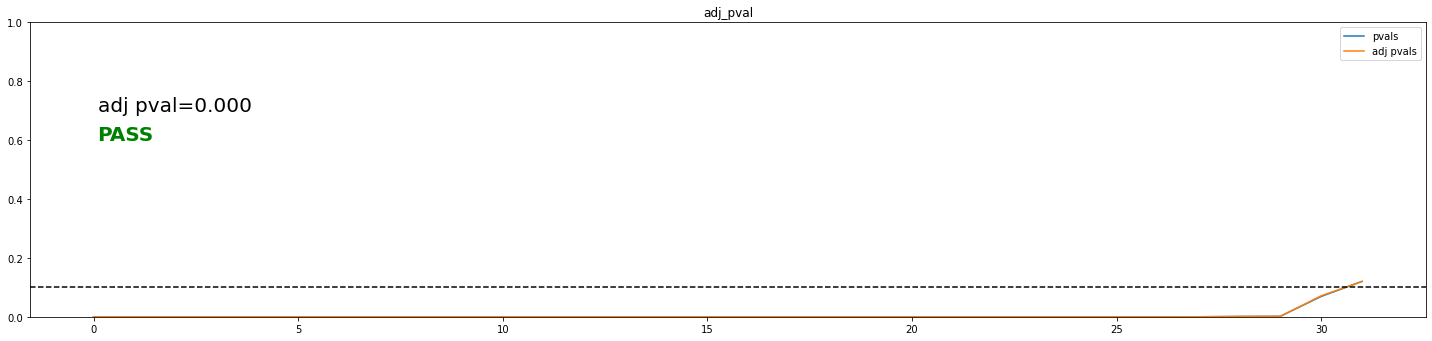

In [8]:
plotter.plot_multiple_tests_adjustment(
    threshold=eval_config["bh_adj_threshold"], mode=eval_config["mode"]
)

In [9]:
pnl_stats = evaluator.calculate_stats(mode=eval_config["mode"], target_volatility=eval_config["target_volatility"])
pnl_stats.loc[["signal_quality", "correlation"]]

Calculating positions:   0%|          | 0/32 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/32 [00:00<?, ?it/s]

Calculating stats:   0%|          | 0/32 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  war

0          1         2   \
signal_quality sharpe_ratio                    10.616637   6.076729   5.08902   
               sharpe_ratio_standard_error      0.348699   0.327211  0.323966   
               sr.tval                         33.580795  19.220909  16.09675   
               sr.pval                               0.0        0.0       0.0   
               kratio                           16.50269    5.03069  7.829203   
               sr_implied_by_prediction_corr   10.635033   5.884243  5.071389   
               sr.adj_pval                           0.0        0.0       0.0   
correlation    prediction_corr_implied_by_pnl   0.872205   0.406065  0.331987   
               prediction_corr                  0.874871   0.391197  0.330711   
               pnl_corr_to_underlying           0.007589   0.005582 -0.069463   

                                                      3         4          5   \
signal_quality sharpe_ratio                     7.263822  0.574856   3.538312   
               sharpe_ratio_standard_error      0.331816  0.316313   0.319984   
               sr.tval                         22.975724   1.81829  11.191807   
               sr.pval                               0.0  0.069135        0.0   
               kratio                           8.609196  0.372699   5.383142   
               sr_implied_by_prediction_corr    7.263334  0.581806   3.505757   
               sr.adj_pval                           0.0  0.071365        0.0   
correlation    prediction_corr_implied_by_pnl    0.50352  0.035614   0.224522   
               prediction_corr                  0.503478  0.036045   0.222354   
               pnl_corr_to_underlying           0.068032  -0.04345   0.030072   

                                                     6          7          8   \
signal_quality sharpe_ratio                    2.086426   4.369204   4.619417   
               sharpe_ratio_standard_error     0.317529   0.321945   0.322614   
               sr.tval                         6.599438  13.819947  14.611379   
               sr.pval                              0.0        0.0        0.0   
               kratio                          2.336642   3.752922   5.859774   
               sr_implied_by_prediction_corr   2.128432   4.430861   4.479268   
               sr.adj_pval                          0.0        0.0        0.0   
correlation    prediction_corr_implied_by_pnl  0.130269   0.280988   0.298471   
               prediction_corr                 0.132937   0.285273   0.288648   
               pnl_corr_to_underlying          0.001055   0.014332   0.000136   

                                                     9   ...         22  \
signal_quality sharpe_ratio                    2.792769  ...   4.901288   
               sharpe_ratio_standard_error     0.318567  ...    0.32341   
               sr.tval                         8.833626  ...  15.502948   
               sr.pval                              0.0  ...        0.0   
               kratio                          3.592652  ...   6.397235   
               sr_implied_by_prediction_corr   2.790627  ...   4.950053   
               sr.adj_pval                          0.0  ...        0.0   
correlation    prediction_corr_implied_by_pnl  0.175554  ...   0.318472   
               prediction_corr                 0.175415  ...   0.321967   
               pnl_corr_to_underlying          0.011892  ...  -0.013564   

                                                     23        24         25  \
signal_quality sharpe_ratio                    0.491458  1.681929   4.669504   
               sharpe_ratio_standard_error     0.316286  0.317069   0.322752   
               sr.tval                           1.5545  5.319999  14.769807   
               sr.pval                         0.120187       0.0        0.0   
               kratio                          0.733048   2.79096   3.445136   
               sr_implied_by_prediction_corr   0.490881  1.723389   4.73

Calculating positions:   0%|          | 0/32 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/32 [00:00<?, ?it/s]

The corr_df.shape[0]='32' > 20


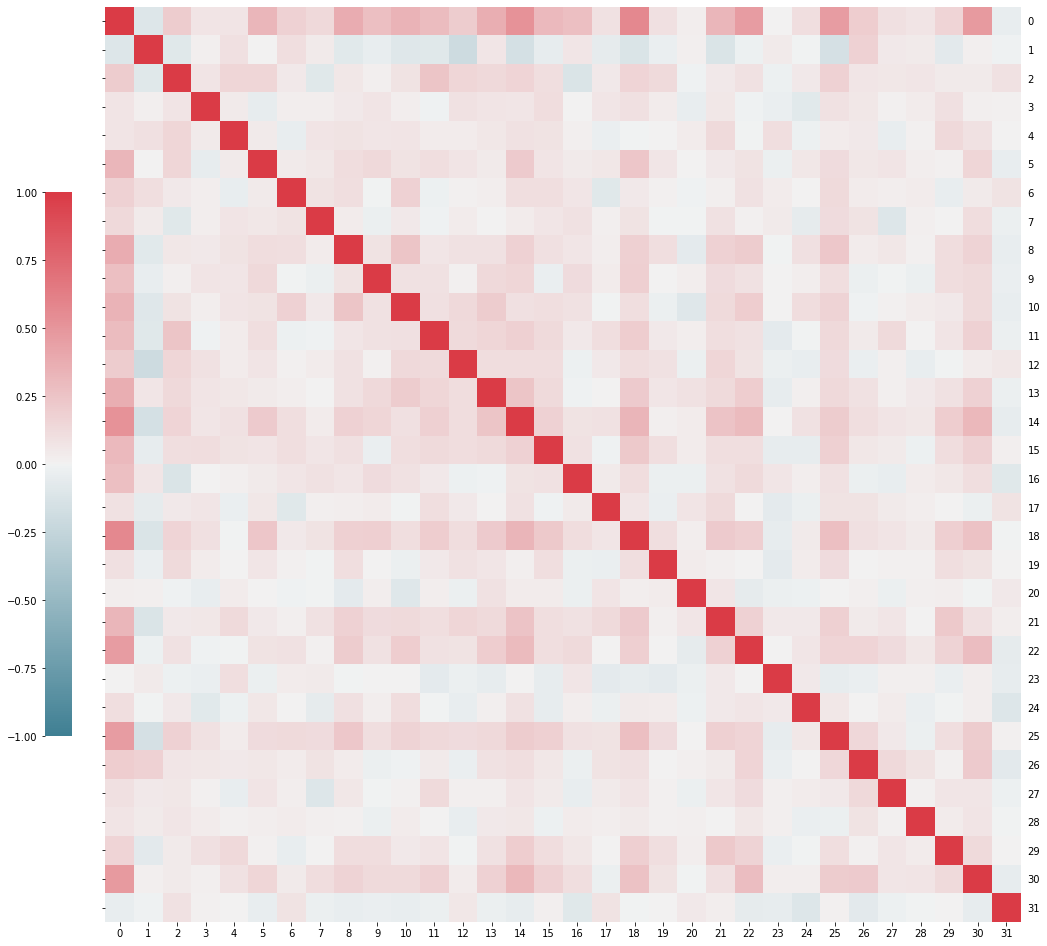

In [10]:
plotter.plot_correlation_matrix(
    series="pnl",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

Calculating positions:   0%|          | 0/32 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/32 [00:00<?, ?it/s]

The corr_df.shape[0]='32' > 20


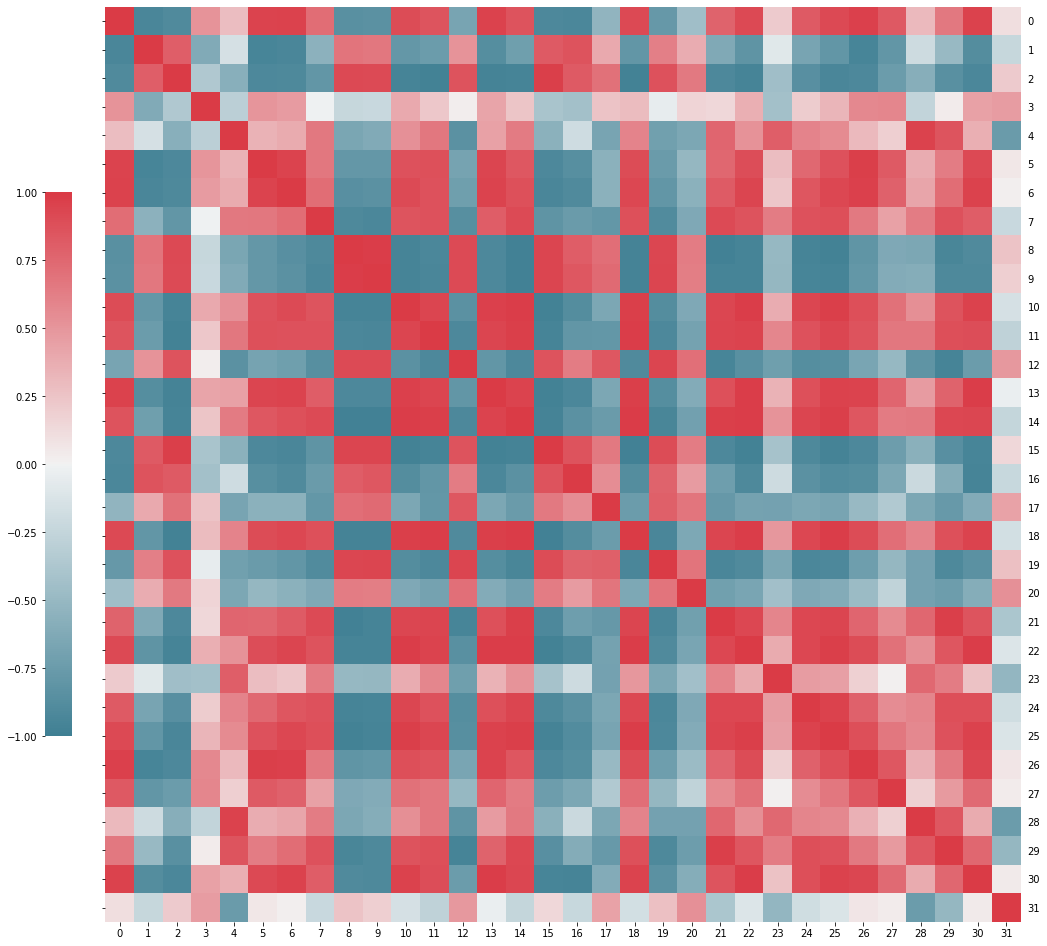

In [11]:
plotter.plot_correlation_matrix(
    series="returns",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

In [12]:
col_mask = pnl_stats.loc["signal_quality"].loc["sr.adj_pval"] < eval_config["bh_adj_threshold"]
selected = pnl_stats.loc[:, col_mask].columns.to_list()

Calculating positions:   0%|          | 0/31 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/31 [00:00<?, ?it/s]

Calculating positions:   0%|          | 0/31 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/31 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


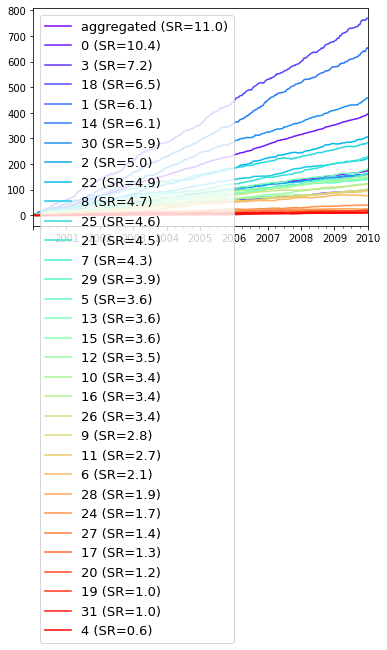

In [13]:
plotter.plot_multiple_pnls(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

In [14]:
evaluator.aggregate_models(
    keys=selected,
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)[2].to_frame()

Calculating positions:   0%|          | 0/31 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/31 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


0
finance     avg_turnover_(%)                            141.770308
            turnover_frequency                       <BusinessDay>
            avg_holding_period                            0.705366
            holding_period_units                     <BusinessDay>
sampling    start_time                         2000-01-03 00:00:00
...                                                            ...
finance     max_drawdown_(%)                              -0.96617
            hit_rate_point_est_(%)                       86.245211
            hit_rate_97.50%CI_lower_bound_(%)            84.883931
            hit_rate_97.50%CI_upper_bound_(%)             87.52616
correlation prediction_corr_implied_by_pnl                1.001784

[63 rows x 1 columns]

Calculating positions:   0%|          | 0/31 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/31 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Upsampling from input freq='B' to freq='D' is blocked


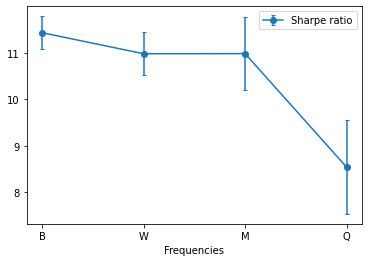

In [15]:
plotter.plot_sharpe_ratio_panel(keys=selected, mode=eval_config["mode"])

Calculating positions:   0%|          | 0/31 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/31 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/app/amp/core/plotting.py:735: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolormesh(t, f_sxx, Sxx)


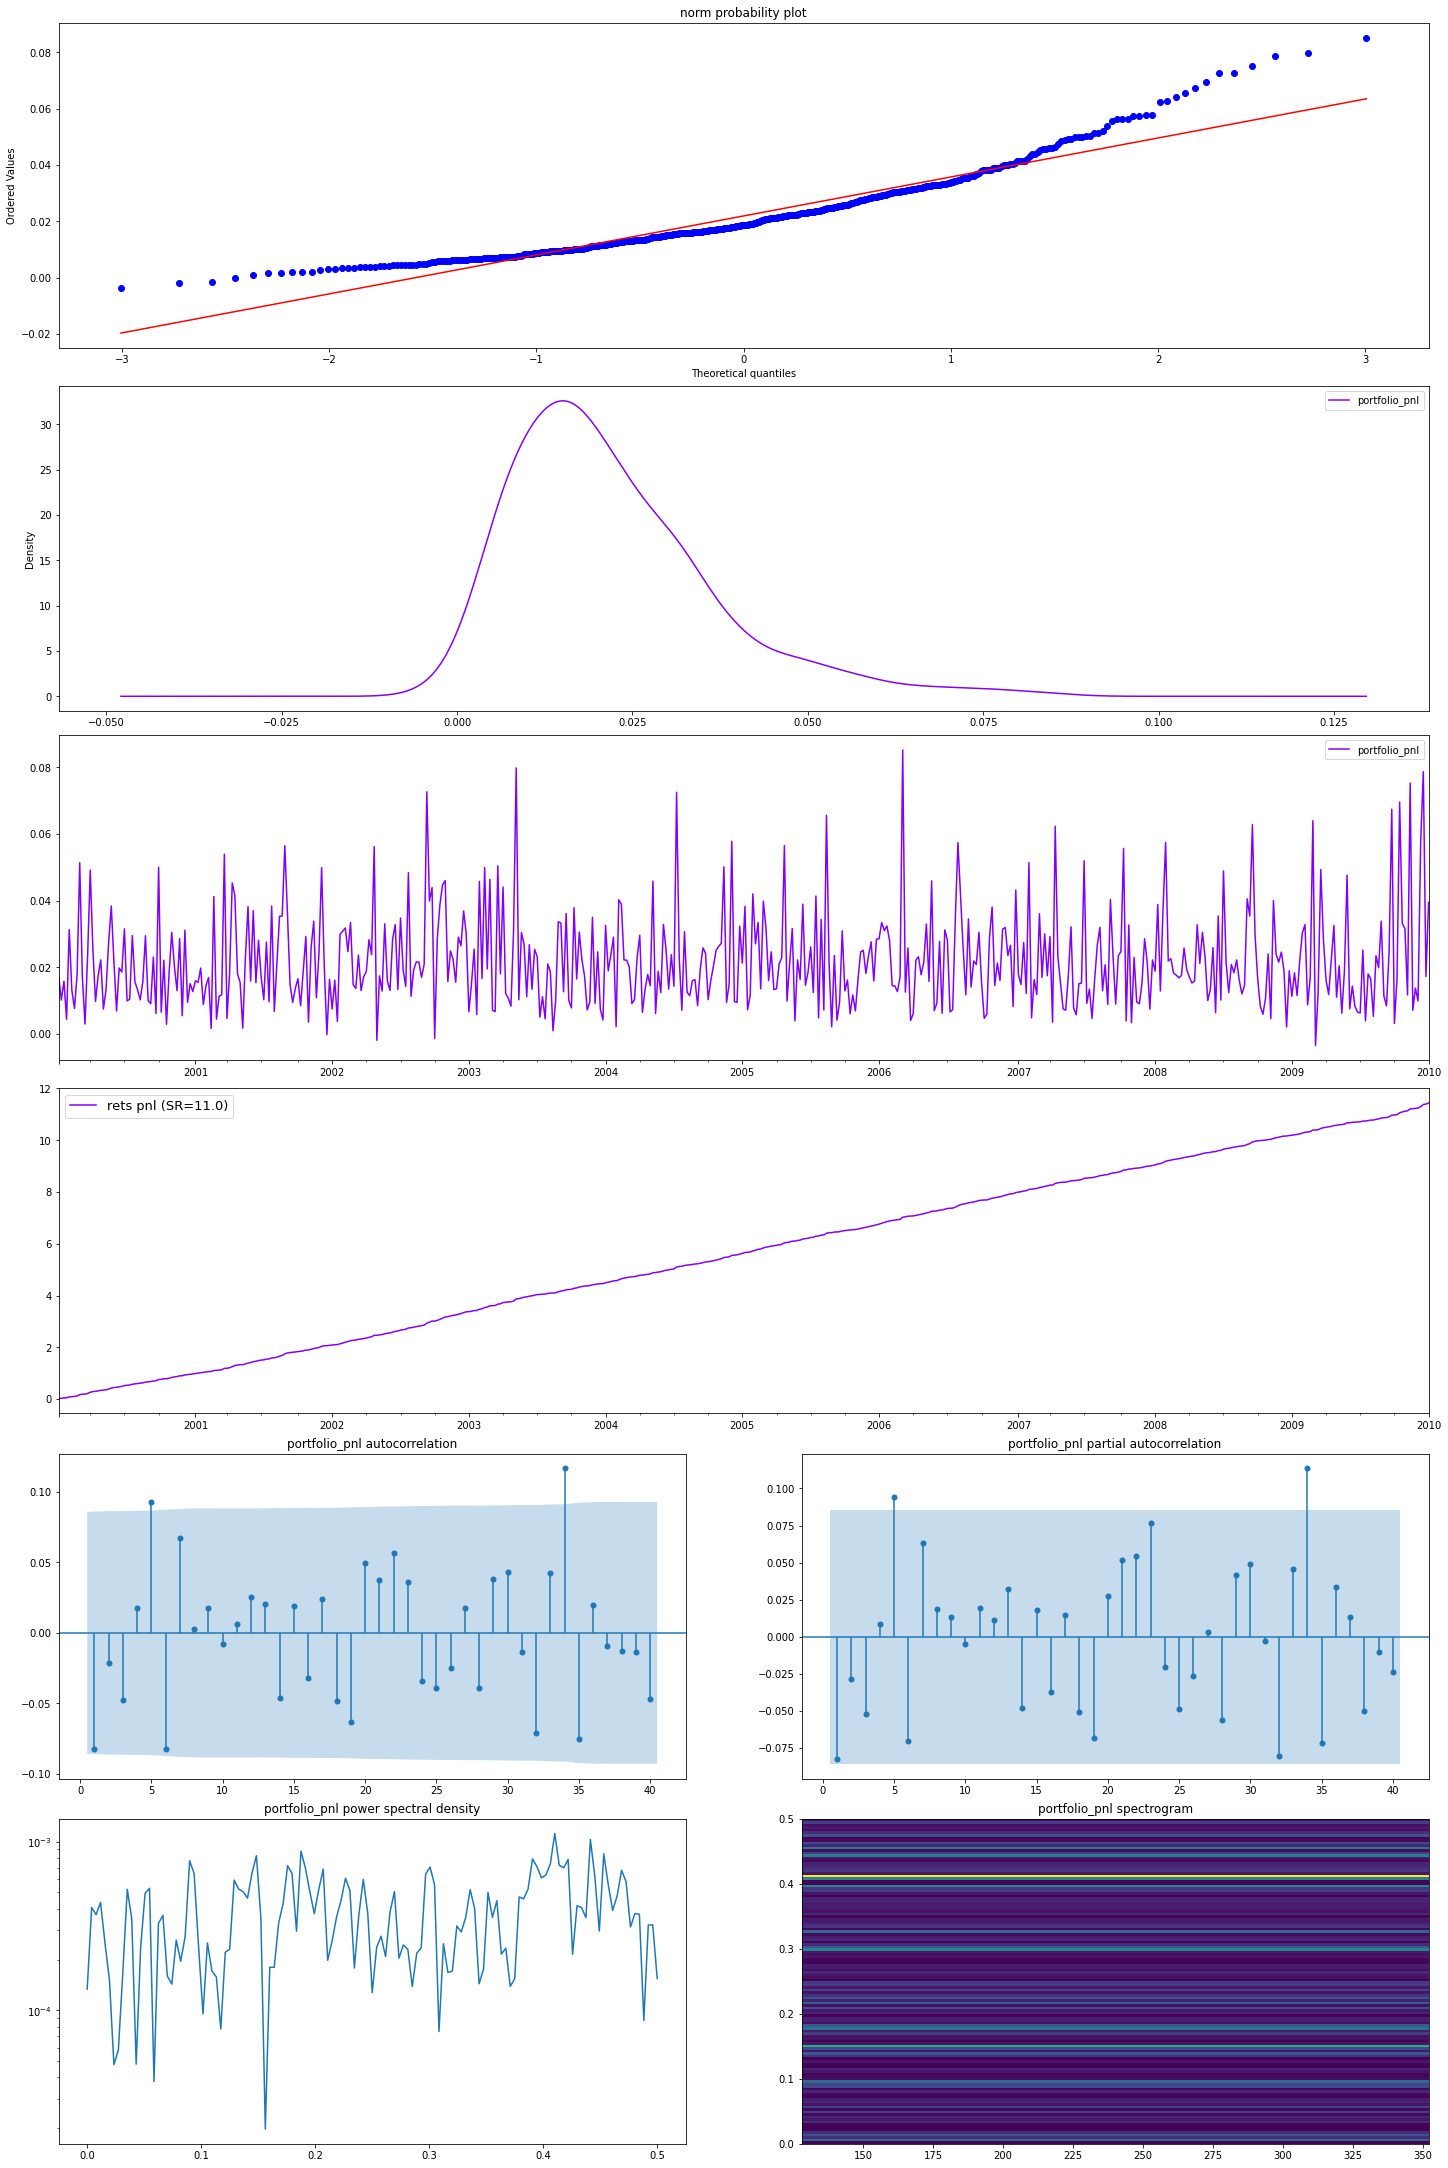

In [16]:
plotter.plot_rets_signal_analysis(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

Calculating positions:   0%|          | 0/31 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/31 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


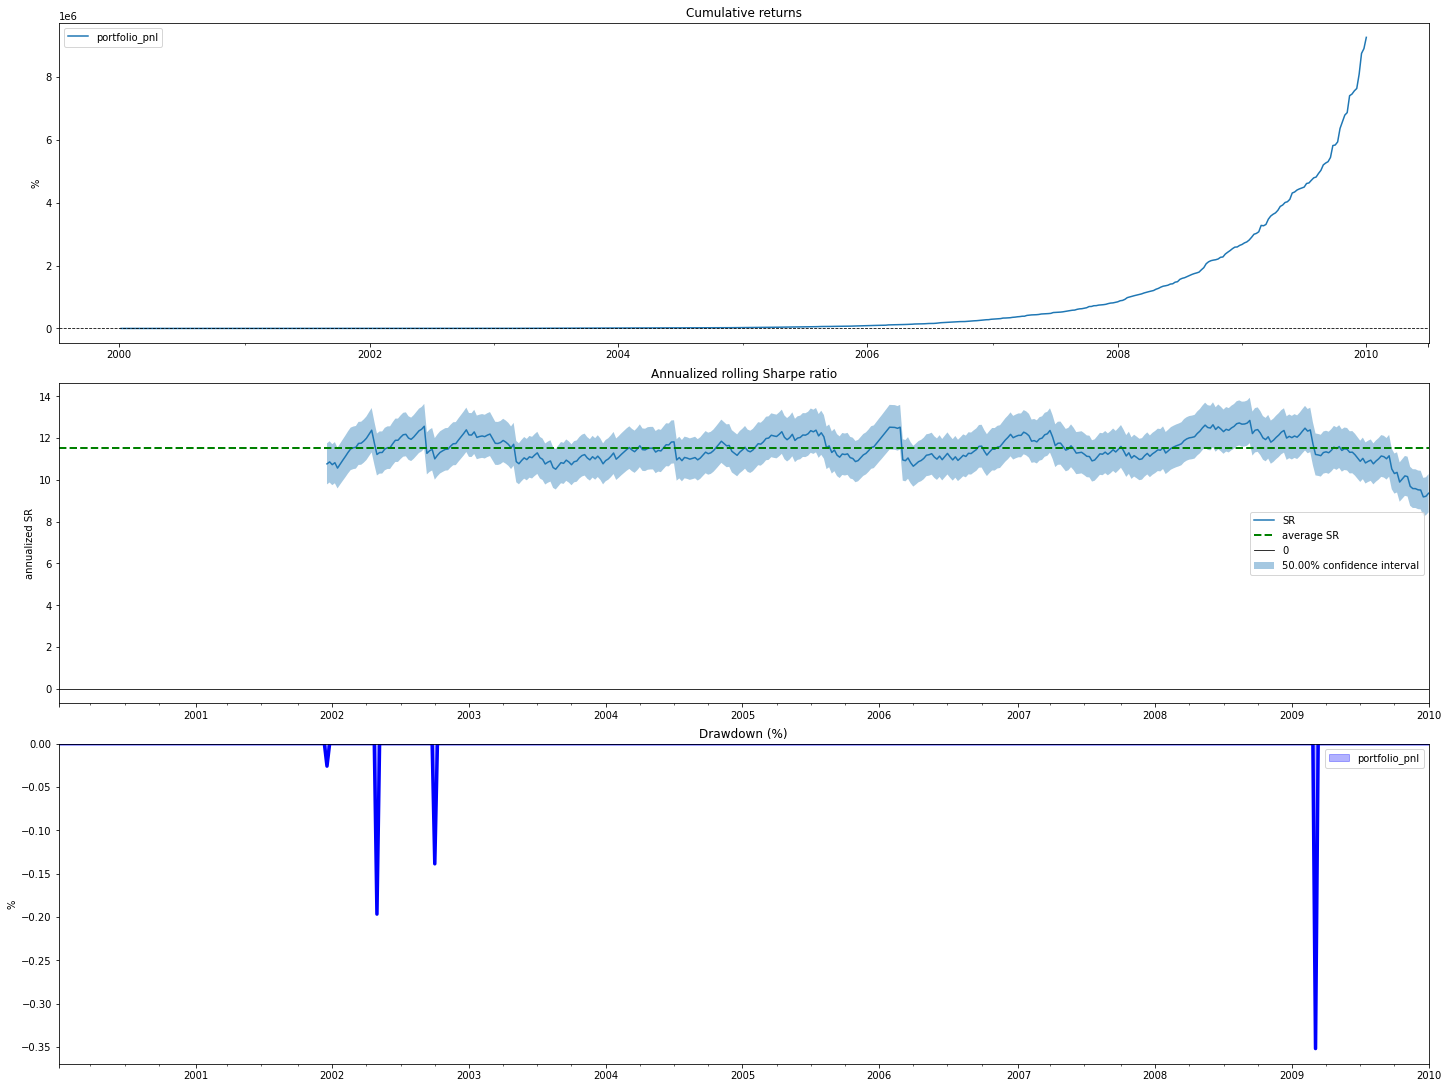

In [17]:
plotter.plot_performance(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

Calculating positions:   0%|          | 0/31 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/31 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


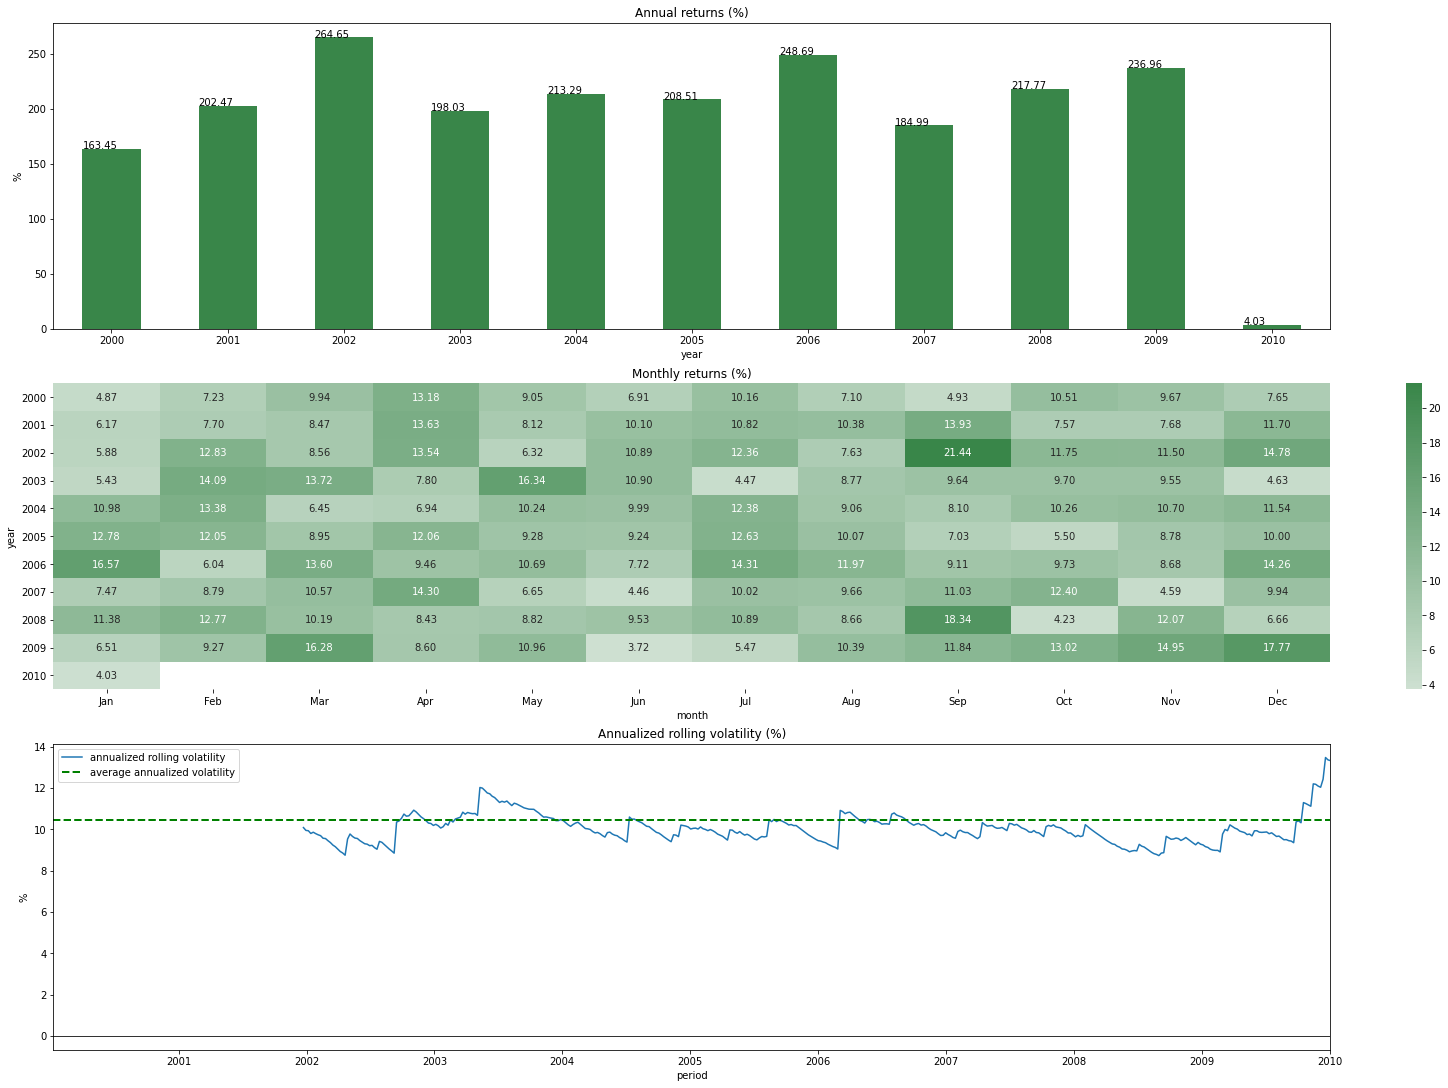

In [18]:
plotter.plot_rets_and_vol(
    selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

Calculating positions:   0%|          | 0/31 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/31 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


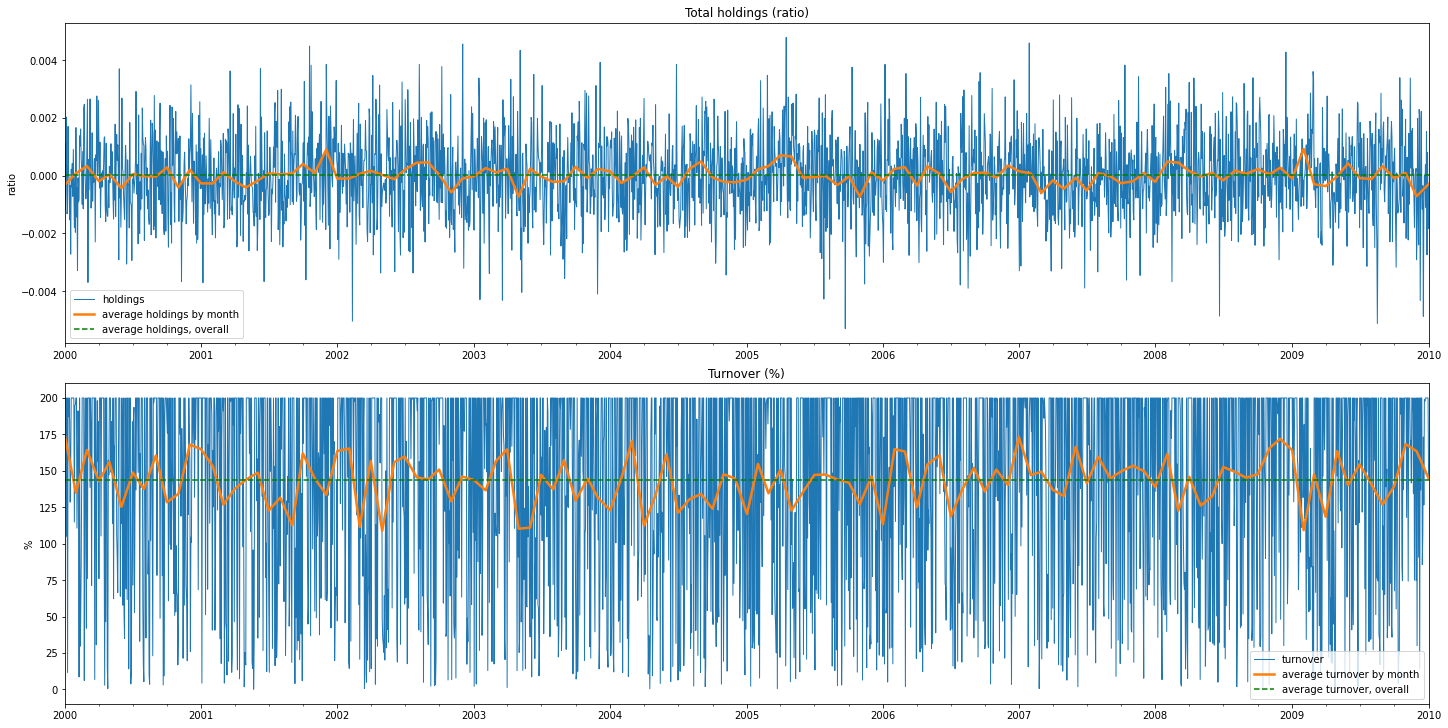

In [19]:
plotter.plot_positions(
    keys=selected,
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

Calculating positions:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating positions:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/1 [00:00<?, ?it/s]

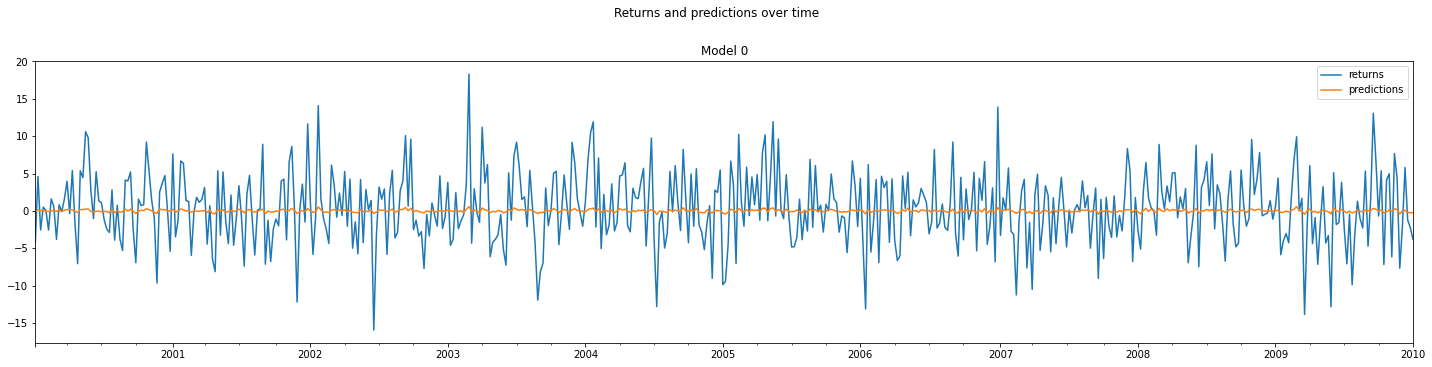

In [20]:
plotter.plot_returns_and_predictions(
    keys=selected[:1],
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)